In [1]:
%load_ext autoreload
%autoreload 2
import pennylane as qml
from pennylane import numpy as np
import pyqsp
import matplotlib.pyplot as plt
import trackhhl.toy.simple_generator as toy
import trackhhl.hamiltonians.simple_hamiltonian as hamiltonian

Python(89344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
from pyqsp import angle_sequence

b=59, j0=21
[PolyOneOverX] minimum [-4.92815952] is at [-0.14616797]: normalizing
[PolyOneOverX] bounding to 0.5
[pyqsp.PolyOneOverX] pcoefs=[ 0.00000000e+00  5.98556692e+00  0.00000000e+00 -1.73435642e+02
  0.00000000e+00  3.28107630e+03  0.00000000e+00 -4.52832142e+04
  0.00000000e+00  4.80871385e+05  0.00000000e+00 -4.03390187e+06
  0.00000000e+00  2.70789137e+07  0.00000000e+00 -1.46432056e+08
  0.00000000e+00  6.40422624e+08  0.00000000e+00 -2.27142395e+09
  0.00000000e+00  6.54450332e+09  0.00000000e+00 -1.53259059e+10
  0.00000000e+00  2.91387383e+10  0.00000000e+00 -4.48339014e+10
  0.00000000e+00  5.54887226e+10  0.00000000e+00 -5.46999791e+10
  0.00000000e+00  4.23016219e+10  0.00000000e+00 -2.50751640e+10
  0.00000000e+00  1.09875684e+10  0.00000000e+00 -3.35056719e+09
  0.00000000e+00  6.34463590e+08  0.00000000e+00 -5.61508354e+07]


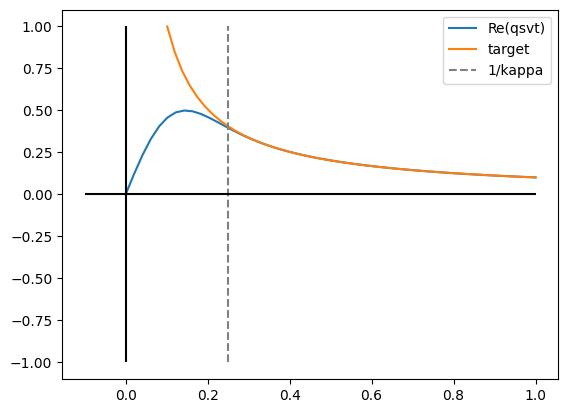

In [3]:
kappa = 4
s = 0.10145775
pcoefs, s = pyqsp.poly.PolyOneOverX().generate(kappa, return_coef=True, ensure_bounded=True, return_scale=True)
phi_pyqsp = angle_sequence.QuantumSignalProcessingPhases(pcoefs, signal_operator="Wx", tolerance=0.00001)

#phi_pyqsp = [-2.287, 2.776, -1.163, 0.408, -0.16, -0.387, 0.385, -0.726, 0.456, 0.062, -0.468, 0.393, 0.028, -0.567, \
#             0.76, -0.432, -0.011, 0.323, -0.573, 0.82, -1.096, 1.407, -1.735, 2.046, -2.321, 2.569, -2.819, -0.011,  \
#             2.71, -2.382, 2.574, 0.028, -2.749, 2.673, 0.062, -2.685, 2.416, 0.385, -0.387, -0.16, 0.408, -1.163, -0.365, 2.426]

x_vals = np.linspace(0, 1, 50)
target_y_vals = [s * (1 / x) for x in np.linspace(s, 1, 50)]

qsvt_y_vals = []
for x in x_vals:
    poly_x = qml.matrix(qml.qsvt, wire_order=[0])(
        x, phi_pyqsp, wires=[0], convention="Wx"  # specify angles using convention=`Wx`
    )
    qsvt_y_vals.append(np.real(poly_x[0, 0]))

plt.plot(x_vals, np.array(qsvt_y_vals), label="Re(qsvt)")
plt.plot(np.linspace(s, 1, 50), target_y_vals, label="target")

plt.vlines(1 / kappa, -1.0, 1.0, linestyle="--", color="grey", label="1/kappa")
plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -0.1, 1.0, color="black")

plt.legend()
plt.show()

In [4]:
N_MODULES = 3
#test bounds of LX and LY
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/2
)

N_PARTICLES =  8
event = generator.generate_event(N_PARTICLES)

ham = hamiltonian.SimpleHamiltonian(
    epsilon=1e-3,
    gamma=2.0,
    delta=1.0
)

ham.construct_hamiltonian(event=event)
print(np.shape(ham.A.todense()))

[Hit(hit_id=1, x=-4.347528634914009, y=0.16590745097348886, z=2.0, module_id=1, track_id=0), Hit(hit_id=4, x=-0.2199802616685789, y=4.199276953555501, z=2.0, module_id=1, track_id=1), Hit(hit_id=7, x=-0.9638974402999986, y=4.509117560563038, z=2.0, module_id=1, track_id=2), Hit(hit_id=10, x=4.006107623528109, y=2.493562548712945, z=2.0, module_id=1, track_id=3), Hit(hit_id=13, x=1.0779297653707571, y=-0.16971757722467473, z=2.0, module_id=1, track_id=4), Hit(hit_id=16, x=-3.7939127652017866, y=2.5692951699138686, z=2.0, module_id=1, track_id=5), Hit(hit_id=19, x=1.402013928751579, y=1.6550424138086361, z=2.0, module_id=1, track_id=6), Hit(hit_id=22, x=0.30362477564431606, y=-1.3715297397628754, z=2.0, module_id=1, track_id=7)]
[Hit(hit_id=2, x=-6.776315581793343, y=0.25859317777432056, z=3.0, module_id=2, track_id=0), Hit(hit_id=5, x=-0.3428742626007459, y=6.545241732078127, z=3.0, module_id=2, track_id=1), Hit(hit_id=8, x=-1.5023876304117296, y=7.028177650263059, z=3.0, module_id=2, t

In [5]:

def sum_even_odd_circ(x, phi, ancilla_wire, wires):
    phi1, phi2 = phi[: len(phi) // 2], phi[len(phi) // 2:]

    qml.Hadamard(wires=ancilla_wire)  # equal superposition

    # apply even and odd polynomial approx
    qml.ctrl(qml.qsvt, control=(ancilla_wire,), control_values=(0,))(x, phi1, wires=wires)
    qml.ctrl(qml.qsvt, control=(ancilla_wire,), control_values=(1,))(x, phi2, wires=wires)

    qml.Hadamard(wires=ancilla_wire)  # un-prepare superposition

def real_u(A, phi):
    qml.Hadamard(wires="ancilla1")
    wire_A = [i for i in range(int(np.log2(np.shape(A)[0]) + 1))]
    qml.ctrl(sum_even_odd_circ, control=("ancilla1",), control_values=(0,))(A, phi, "ancilla2", wire_A)
    qml.ctrl(qml.adjoint(sum_even_odd_circ), control=("ancilla1",), control_values=(1,))(A.T, phi, "ancilla2", wire_A)

    qml.Hadamard(wires="ancilla1")

A = ham.A.todense()
b = ham.b
print(int(np.log2(len(b))) + 2)

target_x = np.linalg.inv(A) @ b  # true solution

# Normalize states:
norm_b = np.linalg.norm(b)
normalized_b = b / norm_b

norm_x = np.linalg.norm(target_x)
normalized_x = target_x / norm_x
wires = ["ancilla1", "ancilla2"] + [i for i in range(int(np.log2(len(b)) + 1))]
@qml.qnode(qml.device("default.qubit", wires=wires ))
def linear_system_solver_circuit(phi):
    qml.StatePrep(normalized_b, wires=[i for i in range(1,int(np.log2(len(b))) + 1)] )
    real_u(A.T, phi)  # invert the singular values of A transpose to get A^-1
    return qml.state()


transformed_state = linear_system_solver_circuit(qsvt_y_vals)[:len(b)]  # first 4 entries of the state
rescaled_computed_x = transformed_state * norm_b / s
normalized_computed_x = rescaled_computed_x / np.linalg.norm(rescaled_computed_x)



9


In [6]:
#specs_func = qml.specs(linear_system_solver_circuit)
#specs_func(qsvt_y_vals)


In [7]:
print(qml.draw(linear_system_solver_circuit)(A))

ancilla1: ──H────X─╭●─╭●────╭●────╭●──X─╭●──╭●───────╭●───────╭●───H─┤  State
ancilla2: ─────────╰H─├○────├●────╰H────╰H†─├●───────├○───────╰H†────┤  State
       0: ────────────├QSVT─├QSVT───────────├(QSVT)†─├(QSVT)†────────┤  State
       1: ─╭|Ψ⟩───────├QSVT─├QSVT───────────├(QSVT)†─├(QSVT)†────────┤  State
       2: ─├|Ψ⟩───────├QSVT─├QSVT───────────├(QSVT)†─├(QSVT)†────────┤  State
       3: ─├|Ψ⟩───────├QSVT─├QSVT───────────├(QSVT)†─├(QSVT)†────────┤  State
       4: ─├|Ψ⟩───────├QSVT─├QSVT───────────├(QSVT)†─├(QSVT)†────────┤  State
       5: ─├|Ψ⟩───────├QSVT─├QSVT───────────├(QSVT)†─├(QSVT)†────────┤  State
       6: ─├|Ψ⟩───────├QSVT─├QSVT───────────├(QSVT)†─├(QSVT)†────────┤  State
       7: ─╰|Ψ⟩───────╰QSVT─╰QSVT───────────╰(QSVT)†─╰(QSVT)†────────┤  State


In [8]:
#q_script = qml.tape.QuantumScript(ops=[qml.qsvt(A, qsvt_y_vals, wires=[i for i in range(int(np.log2(np.shape(A)[0]) + 1))])])
##q_script1 = qml.tape.QuantumScript(ops=[qml.ctrl(qml.qsvt, control=('ancilla1',), control_values=(0,))(A, qsvt_y_vals, wires=[i for i in range(int(np.log2(np.shape(A)[0]) + 1))])])
#
#
#print(q_script.expand().draw(decimals=2))

In [9]:
MC_truth = [ 1 if seg.hit_from.track_id == seg.hit_to.track_id else 0 for seg in ham.segments]
c =  np.round(normalized_x, 3)
discretized_c = (c > max(c)*0.8).astype(int)
qc = np.round(normalized_computed_x, 3)
discretized_qc = (c > max(c)*0.8).astype(int)
print(discretized_c)
print(np.mean(discretized_c - discretized_qc ))
print(np.mean(discretized_c - MC_truth ))

[1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1]
0.0
0.0


/Users/xenofonchiotopoulos/Library/Caches/pypoetry/virtualenvs/trackhhl-N_P0s0Sv-py3.11/lib/python3.11/site-packages/matplotlib/transforms.py:766: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


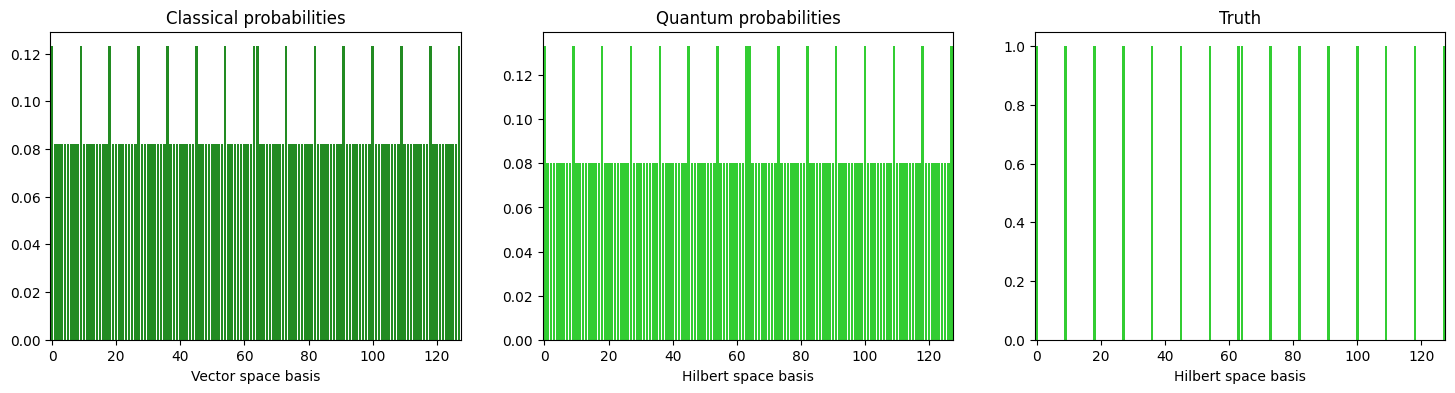

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))



ax1.bar(np.arange(len(normalized_x)), np.round(normalized_x, 3), color="forestgreen")
ax1.set_xlim(-0.5, len(normalized_x) - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(len(normalized_computed_x)), np.round(normalized_computed_x, 3), color="limegreen")
ax2.set_xlim(-0.5, len(normalized_computed_x) - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

ax3.bar(np.arange(len(MC_truth)), np.round(MC_truth, 3), color="limegreen")
ax3.set_xlim(-0.5, len(MC_truth) - 0.5)
ax3.set_xlabel("Hilbert space basis")
ax3.set_title("Truth")


plt.show()

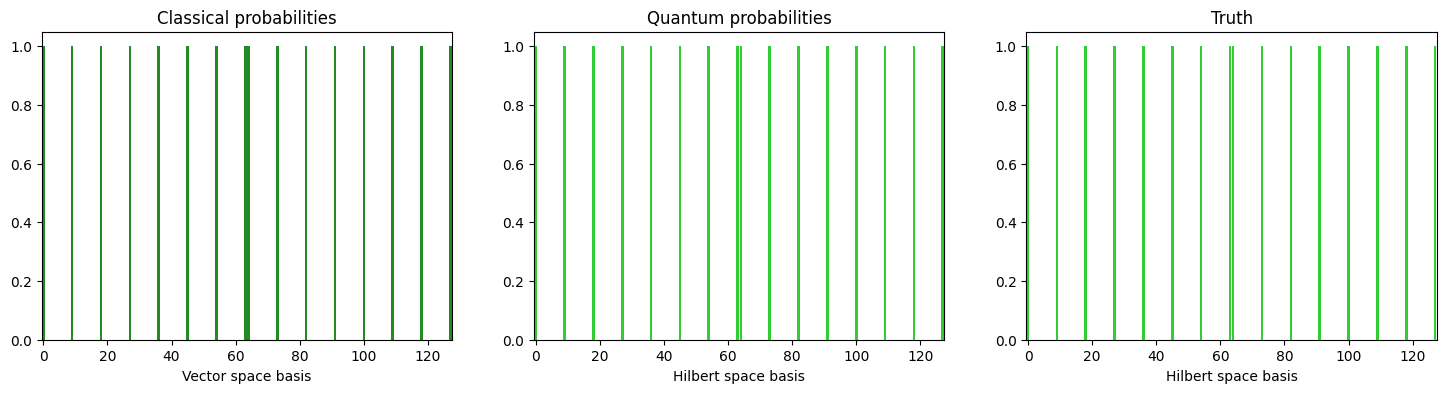

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))



ax1.bar(np.arange(len(normalized_x)), discretized_c, color="forestgreen")
ax1.set_xlim(-0.5, len(normalized_x) - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(len(normalized_computed_x)), discretized_qc, color="limegreen")
ax2.set_xlim(-0.5, len(normalized_computed_x) - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

ax3.bar(np.arange(len(MC_truth)), np.round(MC_truth, 3), color="limegreen")
ax3.set_xlim(-0.5, len(MC_truth) - 0.5)
ax3.set_xlabel("Hilbert space basis")
ax3.set_title("Truth")


plt.show()

In [12]:
expanded_script = q_script.expand().expand().expand()

gate_counts = {}
for op in expanded_script.operations:
  gate_name = op  # First element is the gate name
  if gate_name not in gate_counts:
    gate_counts[gate_name] = 0
  gate_counts[gate_name] += 1

print("Gate Counts:")
counts = 0
for gate, count in gate_counts.items():
  #print(f"{gate}: {count}")
  counts += count 
print('Total Gates: ', counts)

NameError: name 'q_script' is not defined